# Conditional Wassersteing GAN with gradient penalty

In this example a WGAN is built and trained on the spectra dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Load the spectra dataset and skip last few pixels since they do not provide any significant information. The power-of-two shape will help with pooling and upsampling.

In [3]:
data = pd.read_csv("../spectra.csv.gz").values
datax = data[:,:2048]
labels = data[:,-1]
labels = tf.keras.utils.to_categorical(labels)
datax = datax.astype("float32")

Define the dimensionality of inputs, dimensionality of the hidden space and leaking coefficient

In [4]:
inp_dim = datax.shape[1]
n_classes = labels.shape[1]
hidden_dim = 2
a = 0.1

Firstly, define discriminator model. Note the linear activation in the last layer. No batch normalization is used here, since it is not compatible with gradient penalty. Authors suggested usage of layer normalization here, but it is quite computationally-heavy.  
Note usage of linear activation in the last layer.

In [5]:
data_input = Input(shape=(inp_dim,1))

labels_input = Input(shape=(n_classes,))

x = Conv1D(4, 10, padding="same")(data_input)
x = LeakyReLU(a)(x)
x = MaxPool1D(2)(x)

x = Conv1D(4, 20, padding="same")(x)
x = LeakyReLU(a)(x)
x = MaxPool1D(2)(x)

x = Conv1D(8, 20, padding="same")(x)
x = LeakyReLU(a)(x)

x = Flatten()(x)

x = Concatenate()([x, labels_input])

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

discrim_out = Dense(1, activation="linear")(x)

discriminator = Model([data_input, labels_input], discrim_out)

Define generator model. Unfortunately, 1d transposed convolution is not yet available in the stable TF, so we will use simple upsampling.

In [6]:
hidden_input = Input(shape=(hidden_dim,))

x = Concatenate()([hidden_input, labels_input])

x = Dense(8*inp_dim//4, activation="linear")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Reshape((inp_dim//4, 8))(x)

x = Conv1D(8, 20, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)
x = UpSampling1D(2)(x)

x = Conv1D(16, 20, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)
x = UpSampling1D(2)(x)

gen_out = Conv1D(1, 20, padding="same", activation="sigmoid")(x)

generator = Model([hidden_input, labels_input], gen_out)

Define a function that will sample from the $\hat{X}_g=\epsilon X+(1-\epsilon)X_{g},\,\epsilon\sim\mathcal{U}(0,1)$ on the tensor level.

In [7]:
@tf.function
def random_lincomb(x_real, x_gen):
    batch_size = tf.shape(x_real)[0]
    epsilon = tf.random.uniform((batch_size,1,1))
    return epsilon*x_real+(1.0-epsilon)*x_gen

This function generates estimates $$\mathbb{E}_{\hat{{X}}\sim p(\hat{X}_{g})}\big[\max(||\nabla_{\hat{{X}}}D(\hat{{X}})||-1, 0)^{2}\big]$$ by sampling from $\hat{X}_g$, getting gradients at that points and averaging them.  
Scope GradientTape allow differentiation of arbitrary operations inside the scope.  
We need to pass training=True to all operations with model which will be then used to update the weights. This flag is needed for layers, which behave differently in training and testing regimes (such as dropout)

In [8]:
@tf.function
def grad_penalty(real_data, gen_data, labels):
    batch_size = tf.shape(real_data)[0]
    # combine them with real samples and estimate gradients
    lincomb = random_lincomb(real_data, gen_data)
    with tf.GradientTape() as t:
        t.watch(lincomb)
        d_out = discriminator([lincomb, labels], training=True)
        grads = t.gradient(d_out, lincomb)
    # calculate L2 norm (except for batch dimension) and penalty
    l2_grads = tf.math.sqrt(tf.math.reduce_sum(grads**2, axis=[1,2]))
    penalty = tf.math.reduce_mean((tf.math.maximum(l2_grads-1.0, 0.0))**2)
    return penalty

Discriminator tries to find the value of Wasserstein loss by optimizing the objective $$\max_{\theta_{1}}\mathbb{E}_{X\sim\mathbb{{X}}}[D(X,\theta_{1})]-\mathbb{E}_{Z\sim p(Z)}[D(G(Z),\theta_{1})]$$
We will need to change the signs to convert it to the minimization problem

In [9]:
@tf.function
def discriminator_loss(real_data, gen_data):
    # real data: D(X), gen_data: D(G(Z))
    loss = -tf.math.reduce_mean(real_data) + tf.math.reduce_mean(gen_data)
    return loss

Now the generator losses 

$$ \begin{align}
\min_{\theta_{2}}\mathbb{E}_{X\sim\mathbb{{X}}}[D(X)]-\mathbb{E}_{Z\sim p(Z)}[D(G(Z,\theta_{2}))] &= \min_{\theta_2} -\mathbb{E}_{Z\sim p(Z)}[D(G(Z,\theta_{2}))]
\end{align}$$

In [10]:
def generator_loss(pred):
    # pred: D(G(Z))
    return -tf.math.reduce_mean(pred)

Now save the trainable variables (parameters) of both $D$ and $G$ to the variables. This is needed because we will frequently update them, while direct call referencing as discriminator.trainable_variables is slow, since TF is looking for all variables on the access to it.  
Instantiate the optimizers used (according to the original article) and penalty coefficient $\lambda$.

In [11]:
discr_trainable_vars = discriminator.trainable_variables
gen_trainable_vars = generator.trainable_variables

discr_optimizer = Adam(lr=1e-4, beta_1=0.0, beta_2=0.9)
gen_optimizer =  Adam(lr=1e-4, beta_1=0.0, beta_2=0.9)

lmbd = 10.0

The structure of the network is now very different from the classical tf.keras models, so we will not use methods like .fit but will directly update weights of the models by calling optimizer.apply_gradients.

In [12]:
@tf.function
def train_discriminator(data_batch, labels_batch):
    batch_size = tf.shape(data_batch)[0]
    # sample from p(Z) and generate batch of data
    noise = tf.random.normal((batch_size, hidden_dim))
    generated = generator([noise, labels_batch], training=True)
    
    with tf.GradientTape() as t:
        # get both predictions from discriminator, i.e. D(X) and D(G(Z))
        discr_pred_true = discriminator([data_batch, labels_batch], training=True)
        discr_pred_gen = discriminator([generated, labels_batch], training=True)
        # calculate the loss, i.e. approximation of Wass. metric
        wass_loss = discriminator_loss(discr_pred_true, discr_pred_gen)
        # get the gradient penalty and combine them to form total loss
        penalty = grad_penalty(data_batch, generated, labels_batch)
        total_loss = wass_loss+lmbd*penalty
        # calculate gradients of total loss w.r.t. discriminator parameters
        grads = t.gradient(total_loss, discr_trainable_vars)
    # update the weights, according to the calculated gradients
    res_loss = discr_optimizer.apply_gradients(zip(grads, discr_trainable_vars))
    return wass_loss, penalty

Similarly, update the generator weights.

In [13]:
@tf.function
def train_generator(labels_batch):
    # sample from p(Z)
    batch_size = tf.shape(labels_batch)[0]
    noise = tf.random.normal((batch_size, hidden_dim))
    # generate data, predict D(G(Z))
    with tf.GradientTape() as t:
        generated = generator([noise, labels_batch], training=True)
        discr_predicted = discriminator([generated, labels_batch], training=True)
        wass_loss = generator_loss(discr_predicted)
        # get the gradients of W w.r.t. generator weights
        grads = t.gradient(wass_loss, gen_trainable_vars)
    # update generator weights
    discr_optimizer.apply_gradients(zip(grads, gen_trainable_vars))
    return wass_loss

A tiny helper function to shuffle the dataset after end of epoch.

In [14]:
def shuffle(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], Y[indices]

Tune matplotlib style and define a helper function to visualize the spectra.

In [15]:
matplotlib.style.use("ggplot")

def grid_spectra(generator, spec_idx, figsize=(5,5)):
    grid = (5, 5)
    
    x = np.linspace(-1.2, 1.2, grid[0])
    y = np.linspace(-1.2, 1.2, grid[1])
    XX,YY = np.meshgrid(x, y)
    noisegrid = np.vstack([XX.flatten(), YY.flatten()]).T
    labs = np.repeat(tf.keras.utils.to_categorical([spec_idx], n_classes), grid[0]*grid[1], axis=0)
    generated = generator([noisegrid, labs], False)
    idx=1
    plt.figure(figsize=figsize)
    for spec in generated:
        plt.subplot(grid[0], grid[1], idx)
        plt.plot(np.squeeze(spec)[50:1000])
        idx+=1
        plt.xticks([], [])
        plt.yticks([], [])
    plt.tight_layout(-0.2)

Define the training parameters, including number of repeatition during training of discriminator (5, according to the original article), batch size, number of epochs, number of extra steps for discriminator training and visualization frequency.

In [16]:
n_discr = 5
batch_size = 128
n_epochs = 200
discr_extra_steps = 20
summary_every_batches = 100
plot_every_epochs = 10

Finally, train the network as follows  
1) Sample a batch of data from dataset  
2) Train discriminator with this sample for n_discr times.  
3) Update weights of generator to reduce the Wasserstain distance, approximated by discriminator  
4) Each summary_every_batches iteration print the summary. Before printing, train discriminator for a few more epochs to ensure convergence to the Wasserstein distance  
  
Note that the approximated Wasserstein loss is converging to lower values as model trains.

Epoch 0
W estimate: 2.772, grad penlaty: 0.000, gen correction 0.006

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



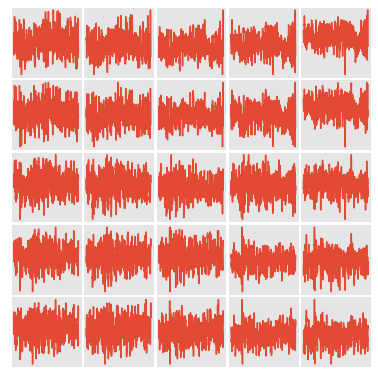

Epoch 1
W estimate: 8.729, grad penlaty: 0.083, gen correction -4.072
Epoch 2
W estimate: 11.868, grad penlaty: 0.170, gen correction -12.868
Epoch 3
W estimate: 12.986, grad penlaty: 0.233, gen correction -17.238
Epoch 4
W estimate: 12.277, grad penlaty: 0.152, gen correction -18.540
Epoch 5
W estimate: 12.548, grad penlaty: 0.224, gen correction -17.377
Epoch 6
W estimate: 12.025, grad penlaty: 0.147, gen correction -19.490
Epoch 7
W estimate: 12.030, grad penlaty: 0.221, gen correction -16.979
Epoch 8
W estimate: 10.599, grad penlaty: 0.121, gen correction -18.008
Epoch 9
W estimate: 11.149, grad penlaty: 0.184, gen correction -15.857
Epoch 10
W estimate: 9.705, grad penlaty: 0.099, gen correction -16.272


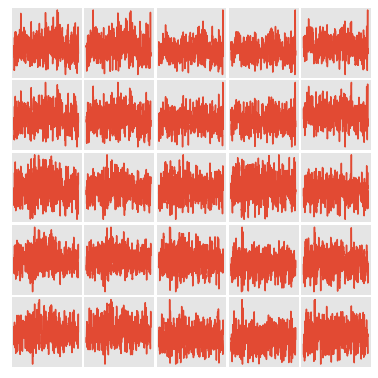

Epoch 11
W estimate: 9.754, grad penlaty: 0.146, gen correction -14.427
Epoch 12
W estimate: 8.655, grad penlaty: 0.085, gen correction -14.744
Epoch 13
W estimate: 9.122, grad penlaty: 0.144, gen correction -13.535
Epoch 14
W estimate: 7.880, grad penlaty: 0.067, gen correction -13.789
Epoch 15
W estimate: 8.004, grad penlaty: 0.132, gen correction -11.993
Epoch 16
W estimate: 7.003, grad penlaty: 0.054, gen correction -12.279
Epoch 17
W estimate: 7.176, grad penlaty: 0.100, gen correction -10.515
Epoch 18
W estimate: 6.428, grad penlaty: 0.052, gen correction -10.784
Epoch 19
W estimate: 6.369, grad penlaty: 0.080, gen correction -9.589
Epoch 20
W estimate: 5.653, grad penlaty: 0.034, gen correction -10.206


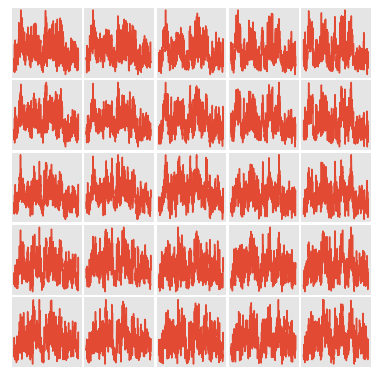

Epoch 21
W estimate: 5.157, grad penlaty: 0.028, gen correction -8.994
Epoch 22
W estimate: 4.797, grad penlaty: 0.027, gen correction -8.361
Epoch 23
W estimate: 4.900, grad penlaty: 0.057, gen correction -7.349
Epoch 24
W estimate: 4.244, grad penlaty: 0.019, gen correction -7.367
Epoch 25
W estimate: 4.371, grad penlaty: 0.049, gen correction -6.274
Epoch 26
W estimate: 3.706, grad penlaty: 0.016, gen correction -6.598
Epoch 27
W estimate: 3.713, grad penlaty: 0.040, gen correction -5.270
Epoch 28
W estimate: 3.476, grad penlaty: 0.014, gen correction -7.165
Epoch 29
W estimate: 3.268, grad penlaty: 0.032, gen correction -4.747
Epoch 30
W estimate: 2.871, grad penlaty: 0.009, gen correction -5.037


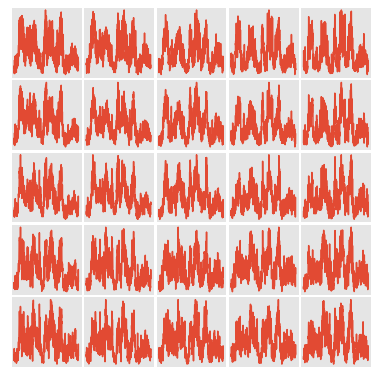

Epoch 31
W estimate: 2.821, grad penlaty: 0.023, gen correction -4.008
Epoch 32
W estimate: 2.604, grad penlaty: 0.007, gen correction -5.105
Epoch 33
W estimate: 2.426, grad penlaty: 0.005, gen correction -3.652
Epoch 34
W estimate: 2.502, grad penlaty: 0.024, gen correction -4.207
Epoch 35
W estimate: 2.343, grad penlaty: 0.018, gen correction -3.004
Epoch 36
W estimate: 2.270, grad penlaty: 0.020, gen correction -2.568
Epoch 37
W estimate: 2.012, grad penlaty: 0.004, gen correction -3.094
Epoch 38
W estimate: 1.982, grad penlaty: 0.006, gen correction -2.562
Epoch 39
W estimate: 1.885, grad penlaty: 0.005, gen correction -2.852
Epoch 40
W estimate: 1.894, grad penlaty: 0.011, gen correction -0.796


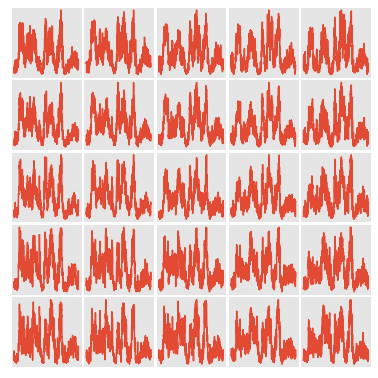

Epoch 41
W estimate: 1.875, grad penlaty: 0.011, gen correction -1.438
Epoch 42
W estimate: 1.805, grad penlaty: 0.009, gen correction -1.206
Epoch 43
W estimate: 1.809, grad penlaty: 0.009, gen correction -1.341
Epoch 44
W estimate: 1.766, grad penlaty: 0.014, gen correction -3.026
Epoch 45
W estimate: 1.652, grad penlaty: 0.007, gen correction -2.389
Epoch 46
W estimate: 1.676, grad penlaty: 0.008, gen correction -1.164
Epoch 47
W estimate: 1.596, grad penlaty: 0.006, gen correction -1.921
Epoch 48
W estimate: 1.593, grad penlaty: 0.008, gen correction -3.338
Epoch 49
W estimate: 1.568, grad penlaty: 0.008, gen correction -0.906
Epoch 50
W estimate: 1.540, grad penlaty: 0.009, gen correction -1.873


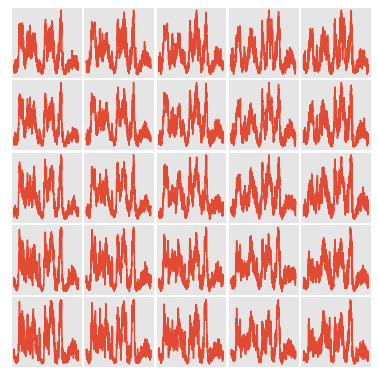

Epoch 51
W estimate: 1.468, grad penlaty: 0.006, gen correction -1.440
Epoch 52
W estimate: 1.503, grad penlaty: 0.008, gen correction -1.678
Epoch 53
W estimate: 1.457, grad penlaty: 0.007, gen correction -2.983
Epoch 54
W estimate: 1.367, grad penlaty: 0.005, gen correction -1.422
Epoch 55
W estimate: 1.439, grad penlaty: 0.009, gen correction -1.952
Epoch 56
W estimate: 1.350, grad penlaty: 0.005, gen correction -1.241
Epoch 57
W estimate: 1.360, grad penlaty: 0.010, gen correction -0.873
Epoch 58
W estimate: 1.296, grad penlaty: 0.005, gen correction -2.148
Epoch 59
W estimate: 1.244, grad penlaty: 0.005, gen correction -0.784
Epoch 60
W estimate: 1.220, grad penlaty: 0.009, gen correction -0.612


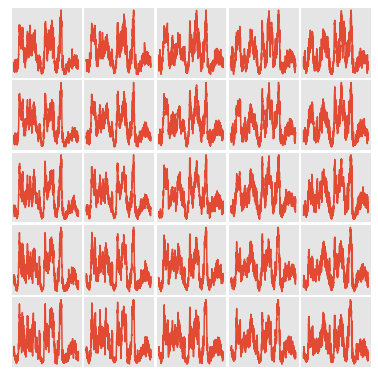

Epoch 61
W estimate: 1.227, grad penlaty: 0.010, gen correction 0.087
Epoch 62
W estimate: 1.117, grad penlaty: 0.005, gen correction -0.253
Epoch 63
W estimate: 1.084, grad penlaty: 0.010, gen correction -1.218
Epoch 64
W estimate: 1.100, grad penlaty: 0.008, gen correction -0.935
Epoch 65
W estimate: 1.093, grad penlaty: 0.006, gen correction -2.888
Epoch 66
W estimate: 1.103, grad penlaty: 0.005, gen correction -1.946
Epoch 67
W estimate: 1.012, grad penlaty: 0.002, gen correction -1.759
Epoch 68
W estimate: 1.072, grad penlaty: 0.004, gen correction -1.620
Epoch 69
W estimate: 1.038, grad penlaty: 0.003, gen correction -1.413
Epoch 70
W estimate: 1.052, grad penlaty: 0.004, gen correction -2.307


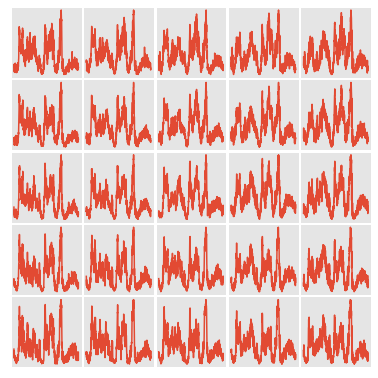

Epoch 71
W estimate: 1.062, grad penlaty: 0.005, gen correction -3.029
Epoch 72
W estimate: 1.087, grad penlaty: 0.005, gen correction -4.595
Epoch 73
W estimate: 1.037, grad penlaty: 0.004, gen correction -1.745
Epoch 74
W estimate: 1.054, grad penlaty: 0.006, gen correction -2.802
Epoch 75
W estimate: 1.032, grad penlaty: 0.005, gen correction -1.915
Epoch 76
W estimate: 0.993, grad penlaty: 0.010, gen correction -2.790
Epoch 77
W estimate: 0.926, grad penlaty: 0.004, gen correction -3.343
Epoch 78
W estimate: 0.969, grad penlaty: 0.005, gen correction -3.467
Epoch 79
W estimate: 0.953, grad penlaty: 0.006, gen correction -1.153
Epoch 80
W estimate: 0.976, grad penlaty: 0.006, gen correction -1.465


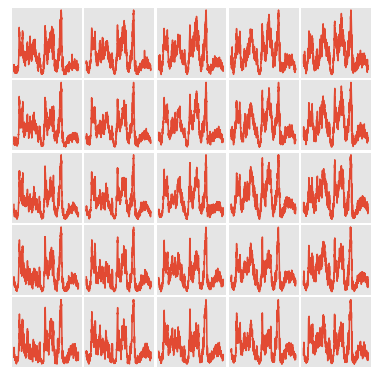

Epoch 81
W estimate: 0.934, grad penlaty: 0.006, gen correction -2.701
Epoch 82
W estimate: 0.887, grad penlaty: 0.005, gen correction -2.649
Epoch 83
W estimate: 0.905, grad penlaty: 0.006, gen correction -0.017
Epoch 84
W estimate: 0.848, grad penlaty: 0.004, gen correction -3.516
Epoch 85
W estimate: 0.923, grad penlaty: 0.008, gen correction -1.056
Epoch 86
W estimate: 0.841, grad penlaty: 0.003, gen correction -2.520
Epoch 87
W estimate: 0.776, grad penlaty: 0.002, gen correction -1.857
Epoch 88
W estimate: 0.790, grad penlaty: 0.002, gen correction -1.608
Epoch 89
W estimate: 0.872, grad penlaty: 0.009, gen correction -3.413
Epoch 90
W estimate: 0.794, grad penlaty: 0.002, gen correction -1.596


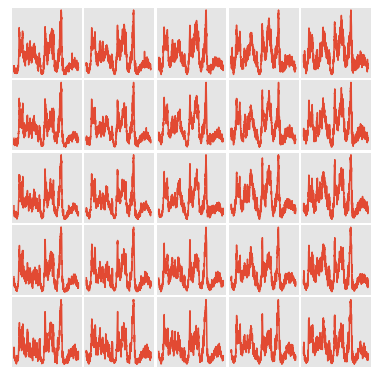

Epoch 91
W estimate: 0.788, grad penlaty: 0.010, gen correction -1.186
Epoch 92
W estimate: 0.747, grad penlaty: 0.006, gen correction -2.514
Epoch 93
W estimate: 0.773, grad penlaty: 0.008, gen correction -1.505
Epoch 94
W estimate: 0.744, grad penlaty: 0.007, gen correction -1.110
Epoch 95
W estimate: 0.709, grad penlaty: 0.003, gen correction -3.483
Epoch 96
W estimate: 0.671, grad penlaty: 0.001, gen correction -1.276
Epoch 97
W estimate: 0.657, grad penlaty: 0.001, gen correction -2.959
Epoch 98
W estimate: 0.802, grad penlaty: 0.010, gen correction -0.852
Epoch 99
W estimate: 0.762, grad penlaty: 0.003, gen correction -4.446
Epoch 100
W estimate: 0.773, grad penlaty: 0.007, gen correction -0.222


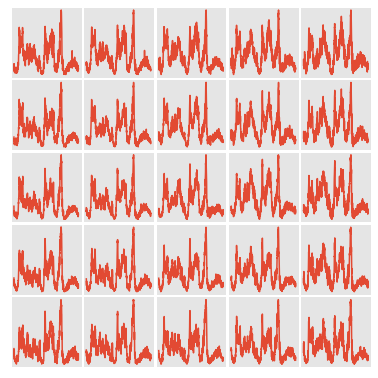

Epoch 101
W estimate: 0.625, grad penlaty: 0.002, gen correction -4.272
Epoch 102
W estimate: 0.709, grad penlaty: 0.006, gen correction -2.076
Epoch 103
W estimate: 0.667, grad penlaty: 0.004, gen correction -3.687
Epoch 104
W estimate: 0.711, grad penlaty: 0.001, gen correction -3.106
Epoch 105
W estimate: 0.674, grad penlaty: 0.004, gen correction -3.959
Epoch 106
W estimate: 0.718, grad penlaty: 0.005, gen correction -2.390
Epoch 107
W estimate: 0.581, grad penlaty: 0.000, gen correction -3.426
Epoch 108
W estimate: 0.674, grad penlaty: 0.001, gen correction -3.155
Epoch 109
W estimate: 0.671, grad penlaty: 0.001, gen correction -4.241
Epoch 110
W estimate: 0.722, grad penlaty: 0.004, gen correction -1.208


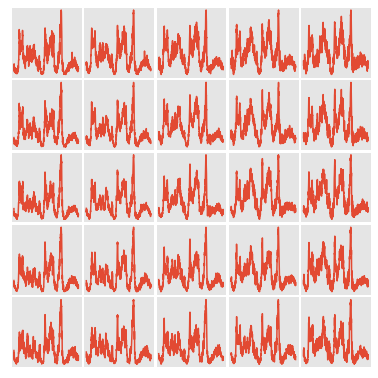

Epoch 111
W estimate: 0.719, grad penlaty: 0.000, gen correction -4.823
Epoch 112
W estimate: 0.794, grad penlaty: 0.005, gen correction -1.442
Epoch 113
W estimate: 0.754, grad penlaty: 0.006, gen correction -5.042
Epoch 114
W estimate: 0.714, grad penlaty: 0.003, gen correction -1.230
Epoch 115
W estimate: 0.694, grad penlaty: 0.003, gen correction -4.656
Epoch 116
W estimate: 0.700, grad penlaty: 0.003, gen correction -1.943
Epoch 117
W estimate: 0.670, grad penlaty: 0.001, gen correction -4.822
Epoch 118
W estimate: 0.704, grad penlaty: 0.004, gen correction -2.783
Epoch 119
W estimate: 0.684, grad penlaty: 0.003, gen correction -3.913
Epoch 120
W estimate: 0.712, grad penlaty: 0.005, gen correction -2.624


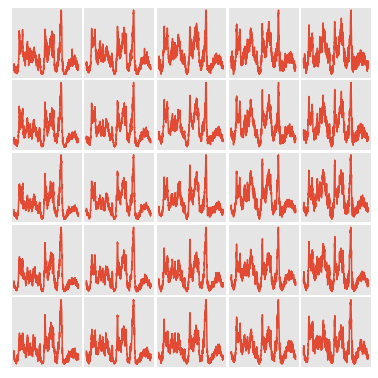

Epoch 121
W estimate: 0.639, grad penlaty: 0.003, gen correction -4.739
Epoch 122
W estimate: 0.755, grad penlaty: 0.003, gen correction -3.470
Epoch 123
W estimate: 0.609, grad penlaty: 0.000, gen correction -4.932
Epoch 124
W estimate: 0.728, grad penlaty: 0.003, gen correction -2.649
Epoch 125
W estimate: 0.700, grad penlaty: 0.002, gen correction -4.506
Epoch 126
W estimate: 0.649, grad penlaty: 0.001, gen correction -2.931
Epoch 127
W estimate: 0.718, grad penlaty: 0.004, gen correction -5.537
Epoch 128
W estimate: 0.788, grad penlaty: 0.002, gen correction -2.565
Epoch 129
W estimate: 0.711, grad penlaty: 0.000, gen correction -4.767
Epoch 130
W estimate: 0.693, grad penlaty: 0.002, gen correction -3.405


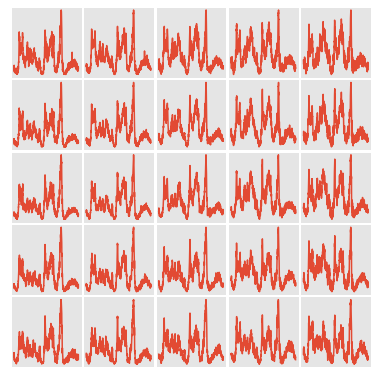

Epoch 131
W estimate: 0.644, grad penlaty: 0.001, gen correction -5.201
Epoch 132
W estimate: 0.666, grad penlaty: 0.001, gen correction -2.442
Epoch 133
W estimate: 0.637, grad penlaty: 0.001, gen correction -5.085
Epoch 134
W estimate: 0.706, grad penlaty: 0.004, gen correction -1.984
Epoch 135
W estimate: 0.690, grad penlaty: 0.001, gen correction -4.813
Epoch 136
W estimate: 0.611, grad penlaty: 0.003, gen correction -2.439
Epoch 137
W estimate: 0.615, grad penlaty: 0.001, gen correction -4.879
Epoch 138
W estimate: 0.620, grad penlaty: 0.001, gen correction -4.106
Epoch 139
W estimate: 0.642, grad penlaty: 0.001, gen correction -4.648
Epoch 140
W estimate: 0.613, grad penlaty: 0.001, gen correction -3.244


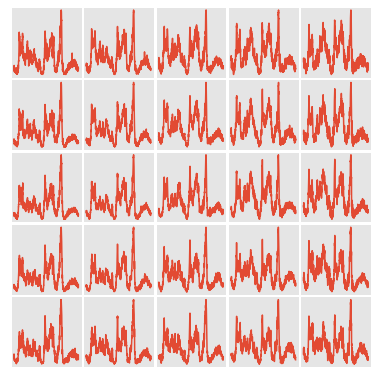

Epoch 141
W estimate: 0.629, grad penlaty: 0.000, gen correction -5.227
Epoch 142
W estimate: 0.749, grad penlaty: 0.004, gen correction -3.560
Epoch 143
W estimate: 0.648, grad penlaty: 0.001, gen correction -5.453
Epoch 144
W estimate: 0.692, grad penlaty: 0.002, gen correction -2.448
Epoch 145
W estimate: 0.629, grad penlaty: 0.001, gen correction -5.597
Epoch 146
W estimate: 0.676, grad penlaty: 0.003, gen correction -3.366
Epoch 147
W estimate: 0.620, grad penlaty: 0.001, gen correction -6.049
Epoch 148
W estimate: 0.637, grad penlaty: 0.002, gen correction -2.499
Epoch 149
W estimate: 0.682, grad penlaty: 0.003, gen correction -5.271
Epoch 150
W estimate: 0.653, grad penlaty: 0.003, gen correction -3.139


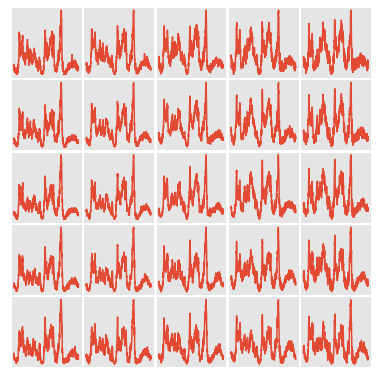

Epoch 151
W estimate: 0.705, grad penlaty: 0.001, gen correction -5.783
Epoch 152
W estimate: 0.803, grad penlaty: 0.002, gen correction -4.245
Epoch 153
W estimate: 0.671, grad penlaty: 0.003, gen correction -5.477
Epoch 154
W estimate: 0.673, grad penlaty: 0.002, gen correction -3.304
Epoch 155
W estimate: 0.701, grad penlaty: 0.001, gen correction -5.756
Epoch 156
W estimate: 0.678, grad penlaty: 0.003, gen correction -2.865
Epoch 157
W estimate: 0.668, grad penlaty: 0.003, gen correction -5.737
Epoch 158
W estimate: 0.733, grad penlaty: 0.006, gen correction -2.512
Epoch 159
W estimate: 0.626, grad penlaty: 0.001, gen correction -6.110
Epoch 160
W estimate: 0.664, grad penlaty: 0.003, gen correction -2.494


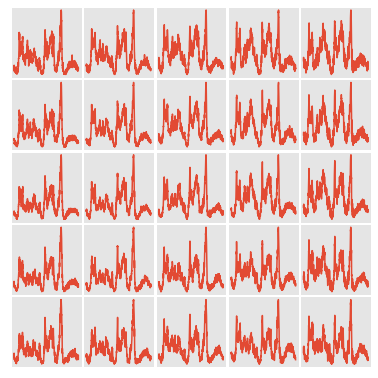

Epoch 161
W estimate: 0.582, grad penlaty: 0.001, gen correction -6.077
Epoch 162
W estimate: 0.698, grad penlaty: 0.005, gen correction -2.368
Epoch 163
W estimate: 0.626, grad penlaty: 0.000, gen correction -5.787
Epoch 164
W estimate: 0.647, grad penlaty: 0.001, gen correction -2.853
Epoch 165
W estimate: 0.689, grad penlaty: 0.003, gen correction -6.121
Epoch 166
W estimate: 0.677, grad penlaty: 0.003, gen correction -3.014
Epoch 167
W estimate: 0.733, grad penlaty: 0.001, gen correction -5.282
Epoch 168
W estimate: 0.617, grad penlaty: 0.003, gen correction -3.321
Epoch 169
W estimate: 0.676, grad penlaty: 0.001, gen correction -5.571
Epoch 170
W estimate: 0.558, grad penlaty: 0.001, gen correction -3.678


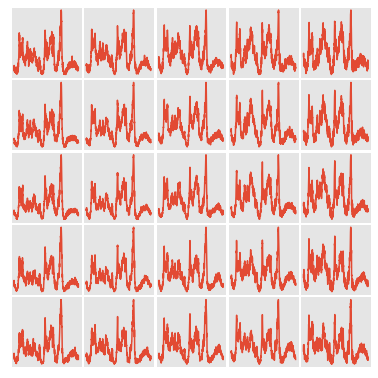

Epoch 171
W estimate: 0.597, grad penlaty: 0.004, gen correction -5.865
Epoch 172
W estimate: 0.629, grad penlaty: 0.003, gen correction -3.123
Epoch 173
W estimate: 0.556, grad penlaty: 0.000, gen correction -5.994
Epoch 174
W estimate: 0.713, grad penlaty: 0.002, gen correction -3.265
Epoch 175
W estimate: 0.658, grad penlaty: 0.003, gen correction -6.171
Epoch 176
W estimate: 0.616, grad penlaty: 0.001, gen correction -2.289
Epoch 177
W estimate: 0.673, grad penlaty: 0.004, gen correction -6.217
Epoch 178
W estimate: 0.869, grad penlaty: 0.004, gen correction -1.789
Epoch 179
W estimate: 0.546, grad penlaty: 0.000, gen correction -6.685
Epoch 180
W estimate: 0.663, grad penlaty: 0.003, gen correction -2.618


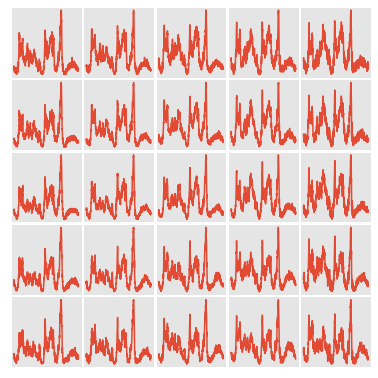

Epoch 181
W estimate: 0.654, grad penlaty: 0.001, gen correction -5.776
Epoch 182
W estimate: 0.636, grad penlaty: 0.001, gen correction -3.270
Epoch 183
W estimate: 0.685, grad penlaty: 0.004, gen correction -6.060
Epoch 184
W estimate: 0.580, grad penlaty: 0.004, gen correction -2.927
Epoch 185
W estimate: 0.579, grad penlaty: 0.002, gen correction -5.499
Epoch 186
W estimate: 0.584, grad penlaty: 0.002, gen correction -3.578
Epoch 187
W estimate: 0.603, grad penlaty: 0.003, gen correction -5.743
Epoch 188
W estimate: 0.634, grad penlaty: 0.003, gen correction -2.617
Epoch 189
W estimate: 0.578, grad penlaty: 0.001, gen correction -6.873
Epoch 190
W estimate: 0.575, grad penlaty: 0.001, gen correction -0.799


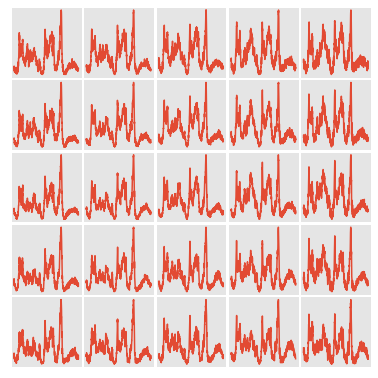

Epoch 191
W estimate: 0.646, grad penlaty: 0.005, gen correction -6.193
Epoch 192
W estimate: 0.581, grad penlaty: 0.002, gen correction -2.603
Epoch 193
W estimate: 0.592, grad penlaty: 0.002, gen correction -6.735
Epoch 194
W estimate: 0.601, grad penlaty: 0.001, gen correction -1.125
Epoch 195
W estimate: 0.613, grad penlaty: 0.001, gen correction -5.682
Epoch 196
W estimate: 0.586, grad penlaty: 0.003, gen correction -3.778
Epoch 197
W estimate: 0.626, grad penlaty: 0.003, gen correction -5.303
Epoch 198
W estimate: 0.579, grad penlaty: 0.005, gen correction -2.854
Epoch 199
W estimate: 0.646, grad penlaty: 0.003, gen correction -6.301


In [17]:
for epoch in range(n_epochs):
    print("Epoch", epoch)
    batch_idx = 0
    # iterating over data in dataset
    for data_idx in range(0, datax.shape[0], batch_size):
        data_batch = datax[data_idx:data_idx + batch_size, :, np.newaxis]
        labels_batch = labels[data_idx:data_idx + batch_size]
        # discriminator is trained on each epochs
        train_discriminator(data_batch, labels_batch)
        # and generator is trained each n_discr epoch, to ensure convergence
        if batch_idx % n_discr == 0:
            w_gen = train_generator(labels_batch)
        # every nth epoch, print summary
        if batch_idx % summary_every_batches == 0:
            for _ in range(discr_extra_steps):
                w_discrim, grad_pen = train_discriminator(data_batch, labels_batch)
            
            print("W estimate: {:.3f}, grad penlaty: {:.3f}, gen correction {:.3f}".format(-w_discrim, 
                                                                                           grad_pen, -w_gen))

        batch_idx += 1
    # visualize
    if epoch % plot_every_epochs == 0:
        grid_spectra(generator, 0)
        plt.show()
    # shuffle in the end of epoch
    datax, labels = shuffle(datax, labels)

And visualize them:

<Figure size 432x288 with 0 Axes>

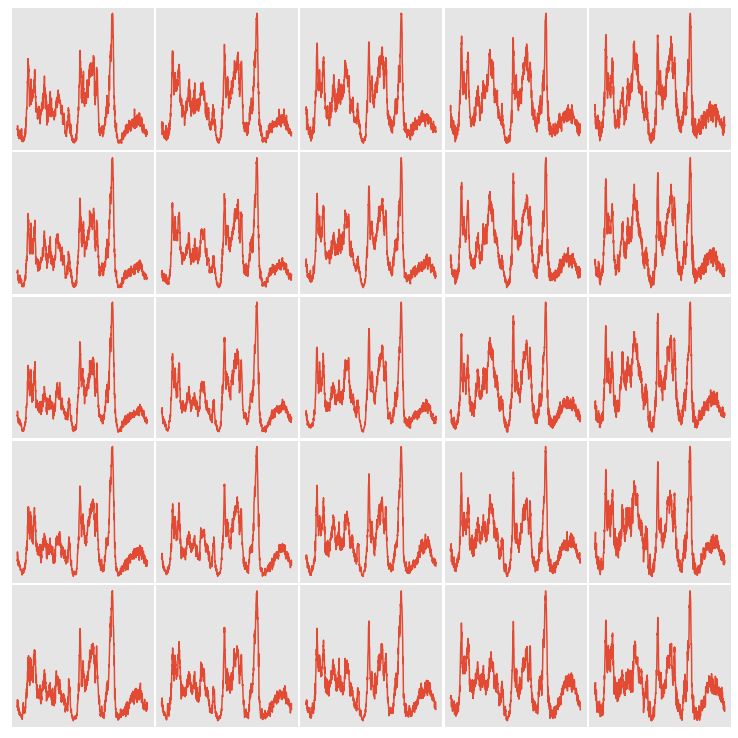

<Figure size 432x288 with 0 Axes>

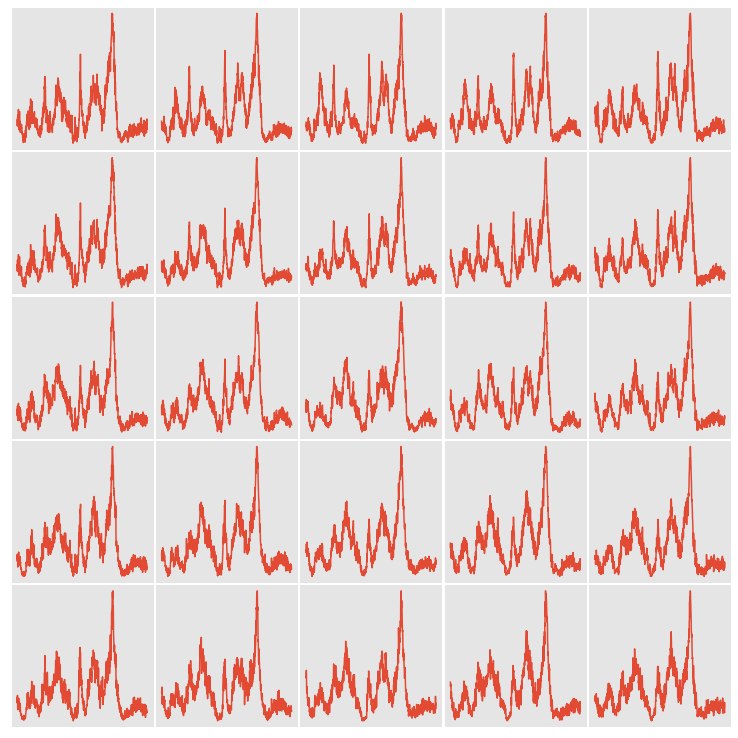

<Figure size 432x288 with 0 Axes>

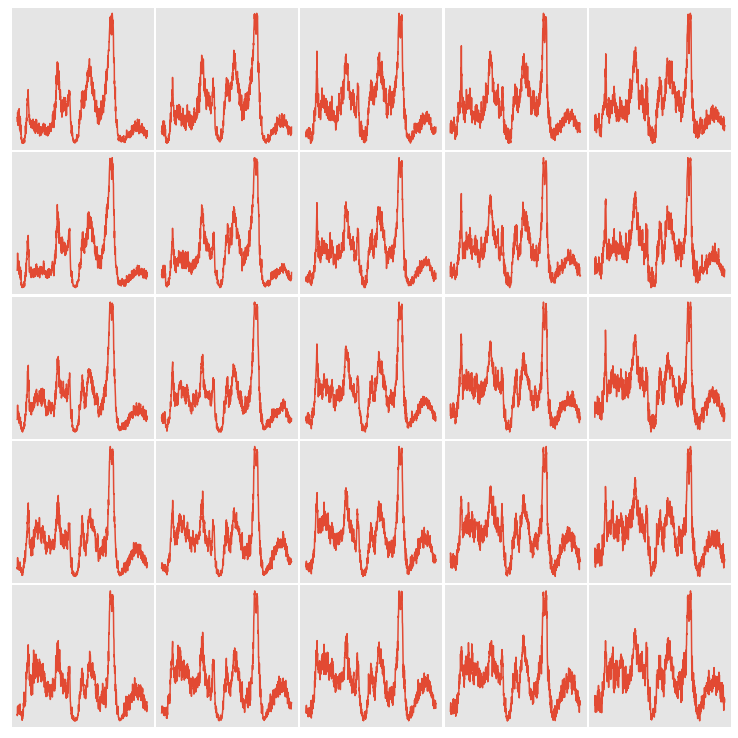

<Figure size 432x288 with 0 Axes>

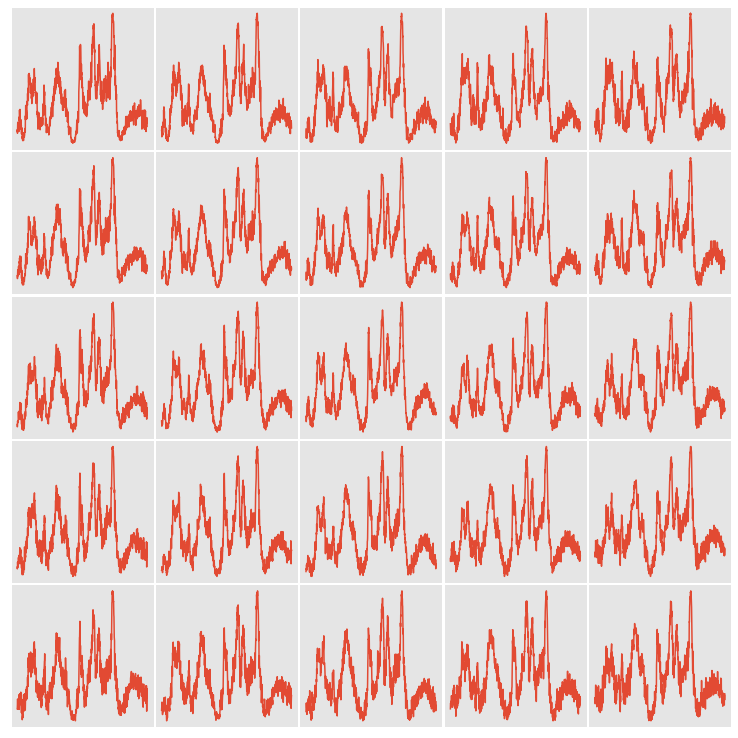

In [18]:
for i in range(n_classes):
    plt.figure()
    grid_spectra(generator, i, (10,10))